# Introduction & Outline

To start, there is two ideas going on here, one being with fake news detection, and another being text summarization. 

For the fake news classification problem, we're working with supervised learning model to predict the output of the neural nets. The data is coming from a dataset on huggingface, so its "clean" data relatively speaking.  Here it's just grabbing headlines, with the text for the article.  It's already divided into train,test, and valdiation datasets.  Working with a dataset is nicer and we can pull some more data from this than the summarization.  Here really I think based on the data and what the goal is, I'll be looking for general text stats, looking at what words are most likely important to this problem, and some topic modeling here as well.

For the text summarization, it is a supervised machine learning problem, some methods that can work for this include text based extraction; which looks for what it considers a key phrase or phrases to return the most important aspects of the document.  Or also there is an abstractive apporach to the is problem too.  I'm more interested in doing the latter.  Which makes this harder to do as usually the text (other some docuemnt) is the data being used and it uses libraries like transformers to do some pretty next level stuff.  Knowing that context matters here though, I think some general info will be helpful here.  Like length of text, word count, tagging 

The frist data set for the project I'm using is on fake news, seems like a topical subject and huggigface

In [73]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\evaluation.csv
data\test.csv
data\train.csv


In [74]:
input_data_path = 'data/'
training_data_file = 'train.csv'
df = pd.read_csv(input_data_path + training_data_file)
df.head()

,id,title,text,label
0,0,Palestinians switch off Christmas lights in Bethlehem in anti-Trump protest,"RAMALLAH, West Bank (Reuters) - Palestinians switched off Christmas lights at Jesus traditional...",1
1,1,China says Trump call with Taiwan president won't change island's status,BEIJING (Reuters) - U.S. President-elect Donald Trump�s call with Taiwan President Tsai Ing-wen ...,1
2,2,FAIL! The Trump Organization�s Credit Score Will Make You Laugh,"While the controversy over Trump s personal tax returns continues, business credit rating compan...",0
3,3,"Zimbabwe military chief's China trip was normal visit, Beijing says",BEIJING (Reuters) - A trip to Beijing last week by Zimbabwe s military chief was a normal milit...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives A Courage Award�Proceeds To Whine About Current Pr...,There has never been a more UNCOURAGEOUS person in the White House than Barack Obama. He never f...,0


### Grabbing total size of the training dataset and general stats

In [75]:
print("size of training dataset: " + str(len(df)))
df.describe(include=['object'])

size of training dataset: 24338


,title,text
count,24338,24338
unique,24047,24337
top,no title,"In its 109-year history, only one F.B.I. director had been fired until Tuesday, when President..."
freq,105,2


### Quick tally of the real vs fake stories

Number of real stories: 13239
Number of fake stories: 11099
total stories: 24338


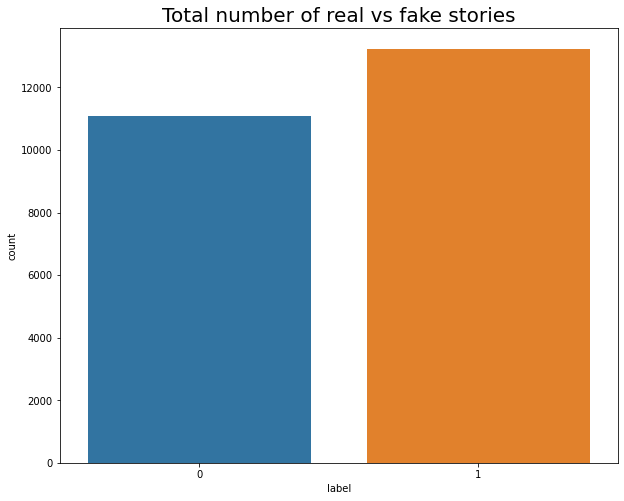

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

trueStories = df.loc[df['label'] == 1]
faketories = df.loc[df['label'] == 0]
print("Number of real stories: " + str(len(trueStories)))
print("Number of fake stories: " + str(len(faketories)))
print("total stories: " + str(len(faketories + trueStories)))

plt.figure(figsize = (10, 8))
ax = sns.countplot(x = df['label'], data = df)
ax.set_title(label = 'Total number of real vs fake stories', fontsize = 20)
plt.show()




# General data analysis
---------------------------------------------------------------------
### length of text(s) and title(s) distribution

In [64]:
df['title_len'] = df['title'].astype(str).apply(len)
df['text_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

array([[<AxesSubplot:title={'center':'title_len'}>,
        <AxesSubplot:title={'center':'text_len'}>],
       [<AxesSubplot:title={'center':'word_count'}>, <AxesSubplot:>]],
      dtype=object)

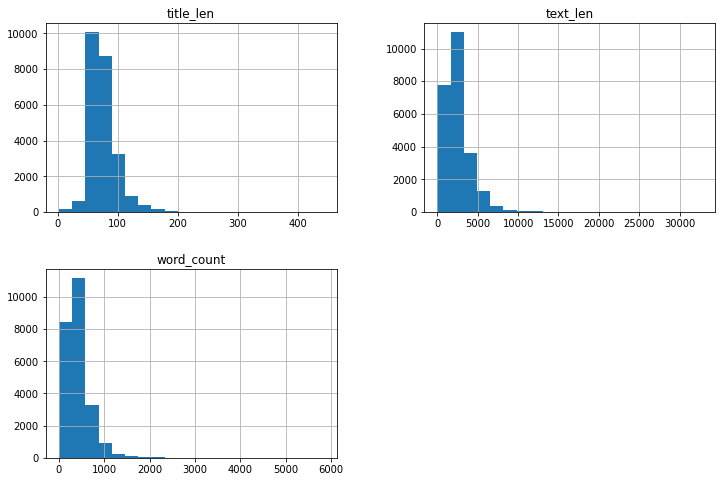

In [65]:
df[["title_len", "text_len", "word_count"]].hist(bins=20, figsize=(12, 8))

It looks like the most common length is around 50 characters, no too surprisingly the text portion of the dataset is much larger and is around 2500 characters.  Breaking it down futher or maybe more meaningfully, in the text for the stoies they are usually about 500 words.  This isn't too relevant for much, maybe other than processing and getting a idea for what it takes to model this data.

In [ ]:
df['text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

# Frequency of words

Characters here may have some value, but really words matter, especially looking at if something is "fake" or not.
seeing what are the most frequent words may show some more interesting details, using a library called wordcloud we can generate a map of words, where the most common are the largest

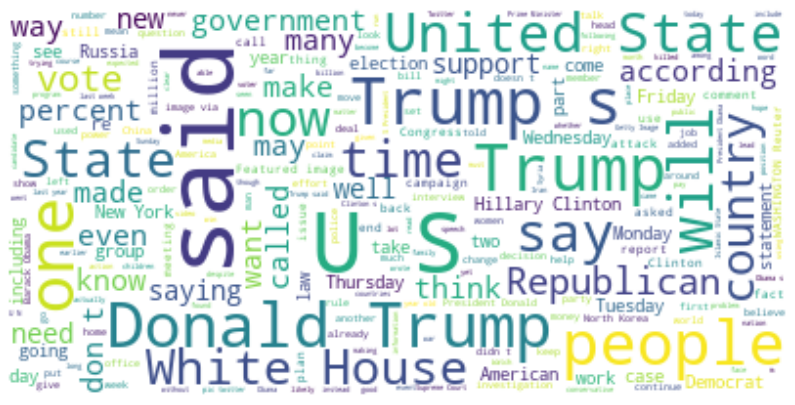

In [51]:
text = " ".join(text for text in df.text)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
wordcl = WordCloud(stopwords = stopwords, background_color='white', max_font_size = 50, max_words = 5000).generate(text)
plt.figure(figsize=(14, 12))
plt.imshow(wordcl, interpolation='bilinear')
plt.axis('off')
plt.show()

Removing stopwords is needed becuase they would be the most frequent, leaving more meaningful data to look at.
Of course not a big shock here, anything political would make sense as politics drive so much of the world today or the news anyway.  By extension, seeing names like Trump is to be expected as well.  

In [49]:
import spacy
nlp = spacy.load("en_core_web_sm")

title = nlp(df['title'].astype(str))

[(x.title,x.label_) for x in title.ents]

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'pandas.core.series.Series'>

## Preprocessing to get "cleaner data" for analysis

In [26]:
import nltk
from collections import Counter
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
import re


## text cleansing

#get rid of special characters

def cleantxt(txt):
    txt = txt.str.replace("()", "")
    txt = txt.str.replace('(<a).*(>).*()', '')
    txt = txt.str.replace('(&amp)', '')
    txt = txt.str.replace('(&gt)', '')
    txt = txt.str.replace('(&lt)', '')
    txt = txt.str.replace('(\xa0)', ' ')
    txt = txt.str.replace("~", "")
    txt = txt.str.replace("`", "")
    txt = txt.str.replace("-", "")    
    txt = txt.str.replace("-", "")
    txt = txt.str.replace("_", "")  
    return txtdf['text'] == cleantxt(df['text'])



# convert to lowercase
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# # remove punctuations
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# # remove stopwords
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# df['text'].head()

#---------------------------------------------------------------------------------------------#
## title cleansing
#---------------------------------------------------------------------------------------------#

ttl = " ".join(title for title in df.title)

#get rid of special characters

def cleanTitle(ttl):
    ttl = ttl.str.replace("()", "")
    ttl = ttl.str.replace('(<a).*(>).*()', '')
    ttl = ttl.str.replace('(&amp)', '')
    ttl = ttl.str.replace('(&gt)', '')
    ttl = ttl.str.replace('(&lt)', '')
    ttl = ttl.str.replace('(\xa0)', ' ')
    ttl = ttl.str.replace("~", "")
    ttl = ttl.str.replace("`", "")
    ttl = ttl.str.replace("�", "")    
    ttl = ttl.str.replace("-", "")
    ttl = ttl.str.replace("_", "")  
    return ttldf['title'] == cleanTitle(df['title'])



# convert to lowercase
df['title'] = df['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# # remove punctuations
df['title'] = df['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))


# df['title'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop=set(stopwords.words('english'))

corpus=[]
new= df['title'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<AxesSubplot:>

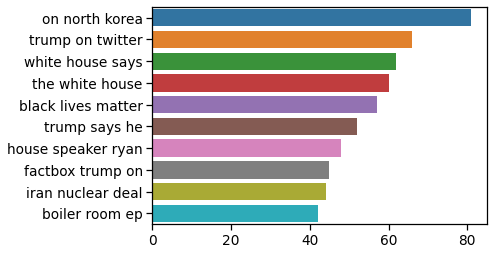

In [32]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

# top_tri_grams=get_top_ngram(df['title'],n=6)
# x,y=map(list,zip(*top_tri_grams))
# sns.barplot(x=y,y=x)

top_n_grams=get_top_ngram(df['title'],n=3)
x,y=map(list,zip(*top_n_grams))
sns.barplot(x=y,y=x)



<AxesSubplot:>

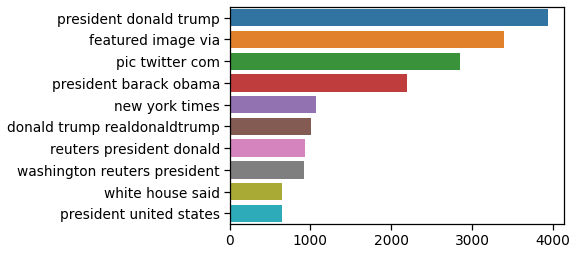

In [33]:
top_n_grams=get_top_ngram(df['text'],n=3)
x,y=map(list,zip(*top_n_grams))
sns.barplot(x=y,y=x)


## Topic Modeling

From looking at the words and their frequencies to seeing which topics the words 

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


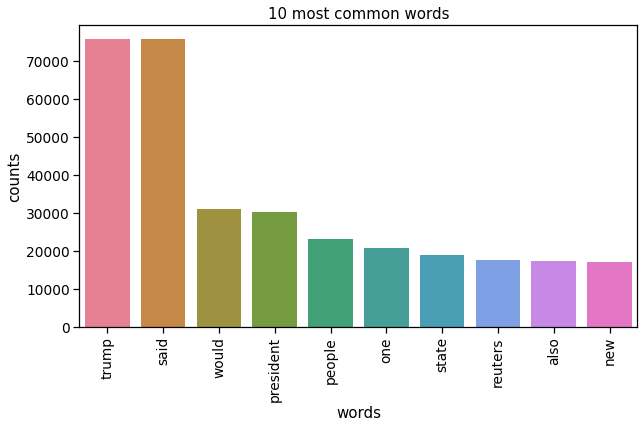

In [61]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.figure(2, figsize=(10, 9/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
# Apply the count vectorized method to our cleaned data
tf = tf_vectorizer.fit_transform(df['text'])
# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
# Visualise the 10 most common words
plot_10_most_common_words(tf, tf_vectorizer)

In [62]:
from sklearn.decomposition import LatentDirichletAllocation

def print_topics(model, count_vectorizer, n_top_words):
    ''' Print the topics detected and the n_top_words that contains
    Input:
       - model: LDA model for the text
       - count_cectorizer: the count vectorizer object
       - n_top_words: the number of words to consider in a topic
    '''
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
 
 # Apply the LDA method to discover the topics
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=10, random_state=0).fit(tf)
# Show the topics and the 8 more relevant words in each topic
no_top_words = 9
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, tf_vectorizer, no_top_words)

Topics found via LDA:

Topic #0:
said police people year city two one gun old

Topic #1:
million said company companies 000 government billion business mexico

Topic #2:
people like one even would us obama right via

Topic #3:
court law state rights states federal justice said supreme

Topic #4:
trump said president house obama white washington republican administration

Topic #5:
said government reuters state minister iran military would islamic

Topic #6:
said north china united korea states nuclear trump south

Topic #7:
would percent said tax bill party republicans year republican

Topic #8:
russia clinton russian investigation fbi intelligence election information campaign

Topic #9:
trump donald clinton campaign twitter hillary republican said presidential


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [79]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df['text']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)   

In [88]:
import gensim

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text)

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

ModuleNotFoundError: No module named 'gensim'

In [ ]:
# import spacy

# text = df['text']
# nlp = spacy.load("en_core_web_sm")

# def ner(text):
#     doc=nlp(text)
#     return [X.label_ for X in doc.ents]

# ent=df['text'].\
#     apply(lambda x : ner(x))
# ent=[x for sub in ent for x in sub]

# counter=Counter(ent)
# count=counter.most_common()

# Text Summarization 

switching over to the text summarization, the dataset is an article from NPR about a research group in Australia that is culturing a chip with literal neurons,
which they taught to play pong.

source: https://www.npr.org/sections/health-shots/2022/10/14/1128875298/brain-cells-neurons-learn-video-game-pong

Based on what I've seen, there's two schools of thought for text summarization: extraction based and abstraction based.  
As the name(s) imply, extraction is going for the text which we would want as its seen as "key" in the text or abstraction
which is creating a unique summary based on the given input.  I think the latter sounds more interesting, so the modeling and methods will reflect that.
However, since this webpage doesn't have the text cleanly, I'm going to cheat abit and have the entire document held in a variable "text".  


In [41]:
import spacy
nlp = spacy.load("en_core_web_sm")

text = nlp("""A dish of living brain cells has learned to play the 1970s arcade game Pong.
About 800,000 cells linked to a computer gradually learned to sense the position of the game's electronic ball and control a virtual paddle, a team reports in the journal Neuron.
The novel achievement is part of an effort to understand how the brain learns, and how to make computers more intelligent.
"We've made huge strides with silicon computing, but they're still rigid and inflexible," says Brett Kagan, an author of the study and chief scientific officer at Cortical Labs in Melbourne, Australia. "That's something we don't see with biology."
For example, both computers and people can learn to make a cup of tea, Kagan says. But people are able to generalize what they've learned in a way a computer can't.
"You might have never been to someone else's house, but with a bit of rummaging and searching you can probably make a decent cup of tea as long as I've got the ingredients," he says. But even a very powerful computer would struggle to carry out that task in an unfamiliar environment.
So Cortical Labs has been trying to understand how living brain cells acquire this sort of intelligence. And Kagan says the Pong experiment was a way for the company to answer a key question about how a network of brain cells learns to change its behavior:
"If we allow these cells to know the outcome of their actions, will they actually be able to change in some sort of goal-directed way," Kagan says.
To find out, the scientists used a system they've developed called DishBrain.A layer of living neurons is grown on a special silicon chip at the bottom of a thumb-size dish filled with nutrients. The chip, which is linked to a computer, can both detect electrical signals produced by the neurons, and deliver electrical signals to them.

To test the learning ability of the cells, the computer generated a game of Pong, a two-dimensional version of table tennis that gained a cult following as one of the first and most basic video games.

Pong is played on a video screen. A black rectangle defines the table, and a white cursor represents each player's paddle, which can be moved up or down to intercept a white ball.

In the simplified version used in the experiment, there was a single paddle on the left side of the virtual table, and the ball would carom off the other sides until it evaded the paddle.

To allow the brain cells to play the game, the computer sent signals to them indicating where the bouncing ball was. At the same time, it began monitoring information coming from the cells in the form of electrical pulses.

"We took that information and we allowed it to influence this Pong game that they were playing," Kagan says. "So they could move the paddle around."

At first, the cells didn't understand the signals coming from the computer, or know what signals to send the other direction. They also had no reason to play the game.

So the scientists tried to motivate the cells using electrical stimulation: a nicely organized burst of electrical activity if they got it right. When they got it wrong, the result was a chaotic stream of white noise.

"If they hit the ball, we gave them something predictable," Kagan says. "When they missed it, they got something that was totally unpredictable."

The strategy was based on the Free Energy Principle, which states that brain cells want to be able to predict what's going on in their environment. So they would choose predictable stimulation over unpredictable stimulation.

The approach worked. Cells began to learn to generate patterns of electrical activity that would move the paddle in front of the ball, and gradually rallies got longer.

The brain cells never got that good at Pong. But interestingly, human brain cells seemed to achieve a slightly higher level of play than mouse brain cells, Kagan says.

And the level of play was remarkable, considering that each network contained fewer cells than the brain of a cockroach, Kagan says.

"If you could see a cockroach playing a game of Pong and it was able to hit the ball twice as often as it was missing it, you would be pretty impressed with that cockroach," he says.

The results hint at a future in which biology helps computers become more intelligent by changing the way that they learn, Kagan says.

But that future is probably still a long way off, says Steve M. Potter, an adjunct associate professor at Georgia Tech.

"The idea of a computer that has some living components is exciting and it's starting to become a reality," he says. "However, the kinds of learning that these things can accomplish is quite rudimentary right now."
""")


[(x.text,x.label_) for x in text.ents]

[('the 1970s', 'DATE'),
 ('Pong', 'GPE'),
 ('About 800,000', 'CARDINAL'),
 ('Neuron', 'GPE'),
 ('Brett Kagan', 'PERSON'),
 ('Cortical Labs', 'ORG'),
 ('Melbourne', 'GPE'),
 ('Australia', 'GPE'),
 ('Kagan', 'PERSON'),
 ('Cortical Labs', 'ORG'),
 ('Kagan', 'PERSON'),
 ('Pong', 'PERSON'),
 ('Kagan', 'PERSON'),
 ('DishBrain', 'PRODUCT'),
 ('Pong', 'GPE'),
 ('two', 'CARDINAL'),
 ('one', 'CARDINAL'),
 ('first', 'ORDINAL'),
 ('Pong', 'PERSON'),
 ('Pong', 'PERSON'),
 ('Kagan', 'PERSON'),
 ('first', 'ORDINAL'),
 ('Kagan', 'PERSON'),
 ('the Free Energy Principle', 'ORG'),
 ('Pong', 'GPE'),
 ('Kagan', 'PERSON'),
 ('Kagan', 'PERSON'),
 ('Pong', 'GPE'),
 ('Kagan', 'PERSON'),
 ('Steve M. Potter', 'PERSON'),
 ('Georgia Tech', 'ORG')]

In [18]:
from spacy import displacy
displacy.render(text, style='ent')

In [61]:
doc = nlp(text)
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})


In [ ]:
doc = nlp(text)
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

Listing out some text data, via textstat a library that has a range of funvtions to compute the complexity of a peice of text

In [58]:
import textstat

text = """A dish of living brain cells has learned to play the 1970s arcade game Pong.
About 800,000 cells linked to a computer gradually learned to sense the position of the game's electronic ball and control a virtual paddle, a team reports in the journal Neuron.
The novel achievement is part of an effort to understand how the brain learns, and how to make computers more intelligent.
"We've made huge strides with silicon computing, but they're still rigid and inflexible," says Brett Kagan, an author of the study and chief scientific officer at Cortical Labs in Melbourne, Australia. "That's something we don't see with biology."
For example, both computers and people can learn to make a cup of tea, Kagan says. But people are able to generalize what they've learned in a way a computer can't.
"You might have never been to someone else's house, but with a bit of rummaging and searching you can probably make a decent cup of tea as long as I've got the ingredients," he says. But even a very powerful computer would struggle to carry out that task in an unfamiliar environment.
So Cortical Labs has been trying to understand how living brain cells acquire this sort of intelligence. And Kagan says the Pong experiment was a way for the company to answer a key question about how a network of brain cells learns to change its behavior:
"If we allow these cells to know the outcome of their actions, will they actually be able to change in some sort of goal-directed way," Kagan says.
To find out, the scientists used a system they've developed called DishBrain.A layer of living neurons is grown on a special silicon chip at the bottom of a thumb-size dish filled with nutrients. The chip, which is linked to a computer, can both detect electrical signals produced by the neurons, and deliver electrical signals to them.

To test the learning ability of the cells, the computer generated a game of Pong, a two-dimensional version of table tennis that gained a cult following as one of the first and most basic video games.

Pong is played on a video screen. A black rectangle defines the table, and a white cursor represents each player's paddle, which can be moved up or down to intercept a white ball.

In the simplified version used in the experiment, there was a single paddle on the left side of the virtual table, and the ball would carom off the other sides until it evaded the paddle.

To allow the brain cells to play the game, the computer sent signals to them indicating where the bouncing ball was. At the same time, it began monitoring information coming from the cells in the form of electrical pulses.

"We took that information and we allowed it to influence this Pong game that they were playing," Kagan says. "So they could move the paddle around."

At first, the cells didn't understand the signals coming from the computer, or know what signals to send the other direction. They also had no reason to play the game.

So the scientists tried to motivate the cells using electrical stimulation: a nicely organized burst of electrical activity if they got it right. When they got it wrong, the result was a chaotic stream of white noise.

"If they hit the ball, we gave them something predictable," Kagan says. "When they missed it, they got something that was totally unpredictable."

The strategy was based on the Free Energy Principle, which states that brain cells want to be able to predict what's going on in their environment. So they would choose predictable stimulation over unpredictable stimulation.

The approach worked. Cells began to learn to generate patterns of electrical activity that would move the paddle in front of the ball, and gradually rallies got longer.

The brain cells never got that good at Pong. But interestingly, human brain cells seemed to achieve a slightly higher level of play than mouse brain cells, Kagan says.

And the level of play was remarkable, considering that each network contained fewer cells than the brain of a cockroach, Kagan says.

"If you could see a cockroach playing a game of Pong and it was able to hit the ball twice as often as it was missing it, you would be pretty impressed with that cockroach," he says.

The results hint at a future in which biology helps computers become more intelligent by changing the way that they learn, Kagan says.

But that future is probably still a long way off, says Steve M. Potter, an adjunct associate professor at Georgia Tech.

"The idea of a computer that has some living components is exciting and it's starting to become a reality," he says. "However, the kinds of learning that these things can accomplish is quite rudimentary right now."
"""

print("ease of readability: " + str(textstat.flesch_reading_ease(text)) + " which is standard")
print("assessed grade level readingis : " + str(textstat.dale_chall_readability_score(text)) + " avg for 10th grade student")
print("there is " + str(textstat.lexicon_count(text, removepunct=True))+ " words in document")
print("there is " + str(textstat.sentence_count(text))+ " sentences in the doucment")


ease of readability: 68.4 which is standard
assessed grade level readingis : 7.75 avg for 10th grade student
there is 806 words in document
there is 41 sentences in the doucment


# Demo of transformer

In [59]:
from transformers import pipeline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

summarizer = pipeline("summarization")


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [60]:
text = """A dish of living brain cells has learned to play the 1970s arcade game Pong.
About 800,000 cells linked to a computer gradually learned to sense the position of the game's electronic ball and control a virtual paddle, a team reports in the journal Neuron.
The novel achievement is part of an effort to understand how the brain learns, and how to make computers more intelligent.
"We've made huge strides with silicon computing, but they're still rigid and inflexible," says Brett Kagan, an author of the study and chief scientific officer at Cortical Labs in Melbourne, Australia. "That's something we don't see with biology."
For example, both computers and people can learn to make a cup of tea, Kagan says. But people are able to generalize what they've learned in a way a computer can't.
"You might have never been to someone else's house, but with a bit of rummaging and searching you can probably make a decent cup of tea as long as I've got the ingredients," he says. But even a very powerful computer would struggle to carry out that task in an unfamiliar environment.
So Cortical Labs has been trying to understand how living brain cells acquire this sort of intelligence. And Kagan says the Pong experiment was a way for the company to answer a key question about how a network of brain cells learns to change its behavior:
"If we allow these cells to know the outcome of their actions, will they actually be able to change in some sort of goal-directed way," Kagan says.
To find out, the scientists used a system they've developed called DishBrain.A layer of living neurons is grown on a special silicon chip at the bottom of a thumb-size dish filled with nutrients. The chip, which is linked to a computer, can both detect electrical signals produced by the neurons, and deliver electrical signals to them.

To test the learning ability of the cells, the computer generated a game of Pong, a two-dimensional version of table tennis that gained a cult following as one of the first and most basic video games.

Pong is played on a video screen. A black rectangle defines the table, and a white cursor represents each player's paddle, which can be moved up or down to intercept a white ball.

In the simplified version used in the experiment, there was a single paddle on the left side of the virtual table, and the ball would carom off the other sides until it evaded the paddle.

To allow the brain cells to play the game, the computer sent signals to them indicating where the bouncing ball was. At the same time, it began monitoring information coming from the cells in the form of electrical pulses.

"We took that information and we allowed it to influence this Pong game that they were playing," Kagan says. "So they could move the paddle around."

At first, the cells didn't understand the signals coming from the computer, or know what signals to send the other direction. They also had no reason to play the game.

So the scientists tried to motivate the cells using electrical stimulation: a nicely organized burst of electrical activity if they got it right. When they got it wrong, the result was a chaotic stream of white noise.

"If they hit the ball, we gave them something predictable," Kagan says. "When they missed it, they got something that was totally unpredictable."

The strategy was based on the Free Energy Principle, which states that brain cells want to be able to predict what's going on in their environment. So they would choose predictable stimulation over unpredictable stimulation.

The approach worked. Cells began to learn to generate patterns of electrical activity that would move the paddle in front of the ball, and gradually rallies got longer.

The brain cells never got that good at Pong. But interestingly, human brain cells seemed to achieve a slightly higher level of play than mouse brain cells, Kagan says.

And the level of play was remarkable, considering that each network contained fewer cells than the brain of a cockroach, Kagan says.

"If you could see a cockroach playing a game of Pong and it was able to hit the ball twice as often as it was missing it, you would be pretty impressed with that cockroach," he says.

The results hint at a future in which biology helps computers become more intelligent by changing the way that they learn, Kagan says.

But that future is probably still a long way off, says Steve M. Potter, an adjunct associate professor at Georgia Tech.

"The idea of a computer that has some living components is exciting and it's starting to become a reality," he says. "However, the kinds of learning that these things can accomplish is quite rudimentary right now."
"""

In [12]:
summary_text = summarizer(text, max_length=130, min_length=30, do_sample=False)[0]['summary_text']
print(summary_text)

 Australian scientists develop a dish of living brain cells that learns to play Pong . The experiment is part of an effort to understand how the brain learns, and how to make computers more intelligent . A computer generated a game of Pong, a two-dimensional version of table tennis that gained a cult following in the 1970s .
